In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Mar  8 09:57:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import numpy as np
import random
import pandas as pd
import os
import time
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import torch
import torch.nn as nn

class EmotionCNN(nn.Module):
    def __init__(self, num_emotions):
        super().__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv1d(1, 256, kernel_size=5, stride=1) # [batch size, 1, 193] -> [batch size, 256, 189]
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, stride=1) # [batch size, 256, 189] -> [batch size, 128, 185]
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv3 = nn.Conv1d(128, 128, kernel_size=5, stride=1) # [batch size, 128, 185] -> [batch size, 128, 181]
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv1d(128, 128, kernel_size=5, stride=1) # [batch size, 128, 181] -> [batch size, 128, 177]
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=8) # [batch size, 128, 177] -> [batch size, 128, 22]

        self.conv5 = nn.Conv1d(128, 128, kernel_size=5, stride=1)
        self.bn5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5, stride=1)
        self.bn6 = nn.BatchNorm1d(128)
        self.relu6 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.2)

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(1792, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_emotions),
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        conv_embedding = self.relu1(self.bn1(self.conv1(x)))
        conv_embedding = self.dropout1(self.relu2(self.bn2(self.conv2(conv_embedding))))
        conv_embedding = self.relu3(self.bn3(self.conv3(conv_embedding)))
        conv_embedding = self.maxpool(self.relu4(self.bn4(self.conv4(conv_embedding))))
        conv_embedding = self.dropout2(self.relu5(self.bn5(self.conv5(conv_embedding))))
        conv_embedding = self.relu6(self.bn6(self.conv6(conv_embedding)))
        # Flatten
        conv_embedding = self.flatten(conv_embedding)
        conv_embedding = self.dropout3(conv_embedding)

        # Fully Connected Layers
        output_logits = self.fc(conv_embedding)
        output_softmax = self.softmax(output_logits)

        return output_logits, output_softmax


In [5]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [6]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [7]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [8]:
X_train = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/xtrain.npy")
X_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/xtest.npy")
X_val = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/xval.npy")

Y_train = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/ytrain.npy")
Y_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/ytest.npy")
Y_val = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/yval.npy")

X_train.shape
# random.shuffle(Y_train)
# random.shuffle(Y_train)
# random.shuffle(Y_train)
# random.shuffle(Y_train)

(7752, 1, 193)

In [9]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
EPOCHS = 250
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 64 # smaller batch size improves val acc (?)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = EmotionCNN(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()))

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-5, momentum=0.8)
# OPTIMIZER = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
# OPTIMIZER = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=1e-6)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses = []
val_losses = []

Selected device is cuda
Number of trainable params:  1022344


In [10]:
start = time.time()
for epoch in range(EPOCHS):
    # shuffle data
    start_epoch = time.time()
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, predictions = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    elapsed_epoch = time.time() - start_epoch
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, "
        f"val_acc:{val_acc:.2f}%, time:{elapsed_epoch:.2f}sec")


 Epoch 0: iteration 120/121
Epoch 0 --> loss:1.7433, acc:31.04%, val_loss:1.2420, val_acc:57.81%, time:3.03sec
 Epoch 1: iteration 120/121
Epoch 1 --> loss:1.2809, acc:49.77%, val_loss:0.7487, val_acc:79.69%, time:1.33sec
 Epoch 2: iteration 120/121
Epoch 2 --> loss:1.0797, acc:56.17%, val_loss:0.5213, val_acc:82.19%, time:1.33sec
 Epoch 3: iteration 120/121
Epoch 3 --> loss:0.9914, acc:58.37%, val_loss:0.4395, val_acc:85.31%, time:1.33sec
 Epoch 4: iteration 120/121
Epoch 4 --> loss:0.9273, acc:59.75%, val_loss:0.4251, val_acc:84.69%, time:1.33sec
 Epoch 5: iteration 120/121
Epoch 5 --> loss:0.8852, acc:61.69%, val_loss:0.4015, val_acc:86.56%, time:1.35sec
 Epoch 6: iteration 120/121
Epoch 6 --> loss:0.8494, acc:63.35%, val_loss:0.3449, val_acc:86.56%, time:1.38sec
 Epoch 7: iteration 120/121
Epoch 7 --> loss:0.8169, acc:64.15%, val_loss:0.3650, val_acc:88.44%, time:1.35sec
 Epoch 8: iteration 120/121
Epoch 8 --> loss:0.8010, acc:64.45%, val_loss:0.3442, val_acc:87.50%, time:1.35sec
 

In [11]:
elapsed = time.time() - start
print(f"Total training time:{elapsed:.2f}sec")

Total training time:381.08sec


# Plot loss

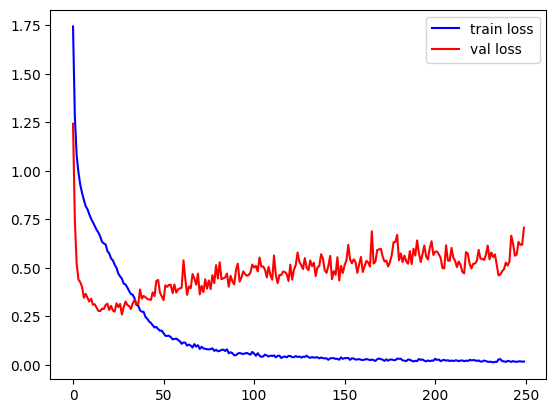

In [12]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])

# Save model

In [15]:
SAVE_PATH = os.path.join(os.getcwd(),'/content/drive/MyDrive/FYP/4_TESS_DG_model/5f base model TESS+RAVDESS(30%)')
# os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'5f_base_Tess+Ravdess(30%)_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'5f_base_Tess+Ravdess(30%)_model.pt')))

Model is saved to /content/drive/MyDrive/FYP/4_TESS_DG_model/5f base model TESS+RAVDESS(30%)/5f_base_Tess+Ravdess(30%)_model.pt


In [16]:
LOAD_PATH = os.path.join(os.getcwd(),'/content/drive/MyDrive/FYP/4_TESS_DG_model/5f base model TESS+RAVDESS(30%)')
model = EmotionCNN(len(EMOTIONS))
# model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'CNN_RAVDESS_model.pt')))
# print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'CNN_RAVDESS_model.pt')))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'5f_base_Tess+Ravdess(30%)_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'5f_base_Tess+Ravdess(30%)_model.pt')))

Model is loaded from /content/drive/MyDrive/FYP/4_TESS_DG_model/5f base model TESS+RAVDESS(30%)/5f_base_Tess+Ravdess(30%)_model.pt


In [17]:
Ravdess_X_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_xtest.npy")
Ravdess_Y_test = np.load(file="/content/drive/MyDrive/FYP/4_TESS_DG_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_ytest.npy")

print(Ravdess_X_test.shape)
print(Ravdess_Y_test.shape)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

validate = make_validate_fnc(model,loss_fnc)

(1008, 1, 193)
(1008,)


In [18]:
device = 'cpu'
print('Selected device is {}'.format(device))

X_test = Ravdess_X_test
Y_test = Ravdess_Y_test

start = time.time()
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor, Y_test_tensor)
elapsed = time.time() - start
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')
print(f"Total test time:{elapsed:.3f}sec")

Selected device is cpu
Test loss is 4.155
Test accuracy is 46.43%
Total test time:1.514sec


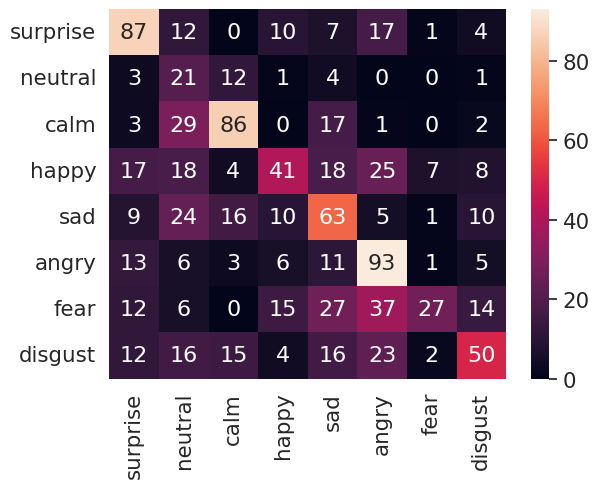

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Rows are the inputs, columns are the classification